In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from google.colab import drive
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from PIL import Image
import math

In [2]:
drive.mount("/content/drive", force_remount=True)
train_path = "/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages"
test_path = "/content/drive/Shareddrives/PokémonAdami/PokémonTrainImages"

Mounted at /content/drive


In [3]:
def show_random_pokemon_image(target_dir, target_class):
  #Setup the target directory (we'll view images from here)
  target_folder = target_dir + "/" +  target_class
  random_image = random.sample(os.listdir(target_folder), 1) #Sample 1 item
  # print(random_image)

  #Read in  the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  # plt.title(target_class.split(".")[1])
  plt.title(target_class)
  plt.axis("off")
  # print(f"Image shape: {img.shape}")

  return img

In [4]:
def data_augmenter():
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
  data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
  
  return data_augmentation

In [5]:
#Plot the validation and trining curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and evaluation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) #how many epochs we've ran

  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #Plot loss
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [6]:
#re-config pred_and_polt
def pred_and_plot(model, img, class_names):
  """
  Imports an image located at filename, make a prediction with model
  and plots the image with the predicted class as the title
  """
  # img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  # print(pred)

  #Add in logic for multiclass and get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
     pred_class = class_names[int(tf.round(pred[0]))]

  #Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

In [7]:
#Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [8]:
#Let's make a create model function to create a model from a url
def create_model(model_url, num_classes, image_shape, data_augmentation=None):
  """
  Takes a tf hub URL and creates a Keras Sequential model with it.
  Args:
    model_url (str): A tf hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer,
                      should be equal to number of target classes, default 10.
    Returns:
      An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons
    """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            name="feature_extraction_layer",
                                            input_shape=image_shape + (3, )) #freeze the already learned patterns
  #Create our own model
  if data_augmentation == None:
    model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])
  else:
      model = tf.keras.Sequential([
      data_augmentation,
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

  return model

In [9]:
pokemon_names = os.listdir(train_path)
print(pokemon_names)
class_names = sorted(pokemon_names)
num_classes = len(class_names)
print(class_names)

['Charizard', 'Venusaur', 'Caterpie', 'Wartortle', 'Bulbasaur', 'Charmander', 'Blastoise', 'Ivysaur', 'Squirtle', 'Charmeleon', 'Pidgeotto', 'Kakuna', 'Rattata', 'Metapod', 'Pidgeot', 'Pidgey', 'Weedle', 'Beedrill', 'Butterfree', 'Raticate', 'Nidorina', 'Arbok', 'Ekans', 'Sandshrew', 'Nidoqueen', 'Spearow', 'Raichu', 'Fearow', 'Pikachu', 'Sandslash', 'Wigglytuff', 'Ninetales', 'Clefairy', 'Nidoking', 'Vulpix', 'Nidorino', 'Clefable', 'Zubat', 'Golbat', 'Jigglypuff', 'Parasect', 'Venomoth', 'Meowth', 'Gloom', 'Oddish', 'Paras', 'Venonat', 'Dugtrio', 'Vileplume', 'Diglett', 'Mankey', 'Poliwhirl', 'Primeape', 'Poliwag', 'Poliwrath', 'Arcanine', 'Growlithe', 'Persian', 'Golduck', 'Psyduck', 'Machamp', 'Victreebel', 'Kadabra', 'Machoke', 'Abra', 'Machop', 'Bellsprout', 'Tentacool', 'Alakazam', 'Weepinbell', 'Ponyta', 'Geodude', 'Graveler', 'Golem', 'Rapidash', 'Slowbro', 'Slowpoke', 'Tentacruel', 'Magnemite', 'Magneton', 'Farfetchd', 'Gastly', 'Dodrio', 'Dewgong', 'Doduo', 'Cloyster', 'Shel

In [ ]:
plt.figure(figsize=(20,100))
for i in range(len(class_names)):
  plt.subplot(51, 3, i + 1)
  folder_name = class_names[i]
  pokemon_img = show_random_pokemon_image(train_path, folder_name)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
train_datagen = ImageDataGenerator(rescale = 1 / 255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1 / 255.)

In [11]:
tf.random.set_seed(42)
print("Training Data:")
train_data = train_datagen.flow_from_directory(directory=train_path,
                                               target_size=(256, 256),
                                               class_mode="categorical",
                                               batch_size=32,
                                               subset="training",
                                               seed=42)
print("Validation Data:")
validation_data = train_datagen.flow_from_directory(directory=train_path,
                                                    target_size=(256, 256),
                                                    class_mode="categorical",
                                                    batch_size=32,
                                                    subset="validation",
                                                    seed=42)
print("Test Data:")
test_data = test_datagen.flow_from_directory(directory=test_path,
                                             target_size=(256, 256),
                                             class_mode="categorical",
                                             batch_size=32,
                                             seed=42)

Training Data:
Found 28102 images belonging to 149 classes.
Validation Data:
Found 6935 images belonging to 149 classes.
Test Data:
Found 1639 images belonging to 149 classes.


In [12]:
len(train_data), len(validation_data), len(test_data)

(879, 217, 52)

In [ ]:
train_images_sample, labels = train_data.next()
len(train_images_sample), len(labels)

(32, 32)

In [ ]:
train_images_sample[0].shape

(256, 256, 3)

Raichu


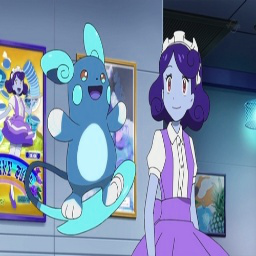

In [ ]:
print(class_names[tf.argmax(labels[0])])
cv2_imshow(train_images_sample[0] * 255)

In [ ]:
validation_images_sample, validation_labels = validation_data.next()
len(validation_images_sample), len(validation_labels)

(32, 32)

Butterfree


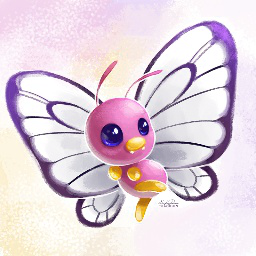

In [ ]:
print(class_names[tf.argmax(validation_labels[9])])
cv2_imshow(validation_images_sample[9] * 255)

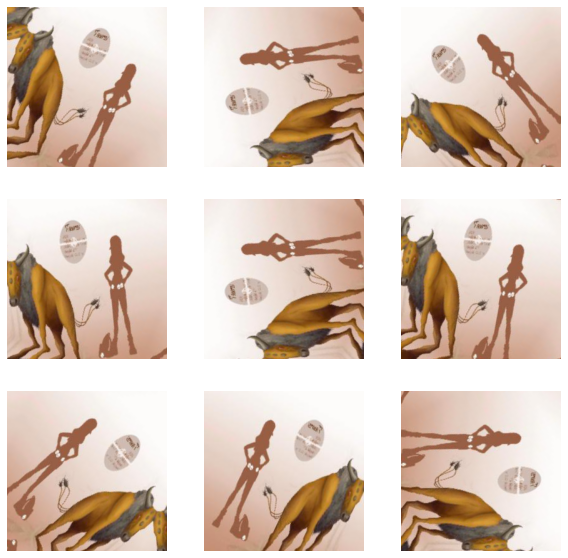

In [ ]:
data_augmentation = data_augmenter()
plt.figure(figsize=(10, 10))
images, _ = train_data.next()
for i in range(9):
  augmented_images = data_augmentation(images * 255.)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0].numpy().astype("uint8"))
  plt.axis("off")

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255,
                            width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             rotation_range=40,
                             fill_mode='nearest'
                            )

In [ ]:
from keras.preprocessing import image
for folders in os.listdir(train_path):
#     defining the image path or the path of folder in which images are present
    images_path = os.path.join(train_path,folders)
#     counting the numvber of image si particular folder
    img_count = len(os.listdir(images_path))
    print(images_path, img_count, folders)
    if img_count <= 107:
        img_arr = os.listdir(images_path)
        
        for img in img_arr:
            
          
            
            
            
            img_ = image.load_img(os.path.join(images_path,img),target_size=(256,256))
            img_ = image.img_to_array(img_)
            img_ = img_.reshape(1,256,256,3)
            
            limit = np.floor(213/img_count)
            # limit = 150
           
            i = 0
            for x in datagen.flow(img_,batch_size=1,save_to_dir = images_path,save_prefix = folders + "_108",save_format = 'jpg'):
                i += 1
                x = x.reshape(256,256,3)
                img = Image.fromarray(x,'RGB')
                pathii = os.path.join(images_path,'save.png')
                img.save(pathii)
                # break
                if i>=limit:
                    break
            # break
    # break

/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Charizard 43 Charizard
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Venusaur 55 Venusaur
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Caterpie 39 Caterpie
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Wartortle 50 Wartortle
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Bulbasaur 278 Bulbasaur
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Charmander 285 Charmander
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Blastoise 51 Blastoise
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Ivysaur 42 Ivysaur
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Squirtle 269 Squirtle
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Charmeleon 54 Charmeleon
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Pidgeotto 52 Pidgeotto
/content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Kakuna 56 Kakuna
/content/driv

In [19]:
for pokemon_name in pokemon_names:
  new_path = train_path + "/" + pokemon_name
  for image in os.listdir(new_path):
    if image == "save.png":
      print(f"Removing {new_path + '/' + image}")
      os.remove(new_path + "/" + image)

Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Charizard/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Venusaur/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Caterpie/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Wartortle/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Blastoise/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Ivysaur/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Charmeleon/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Pidgeotto/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Kakuna/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Rattata/save.png
Removing /content/drive/Shareddrives/PokémonAdami/PokémonQueryImages/Metapod/save.png
Removing /content/drive/Shareddrives/Pokém

In [13]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficient_net_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
efficientnet_model_1 = create_model(efficient_net_url,
                            num_classes=num_classes,
                            image_shape=(256,256),
                            data_augmentation=None)

In [ ]:
efficientnet_model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
efficientnet_model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 149)               190869    
Total params: 4,240,433
Trainable params: 190,869
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_history_1 = efficientnet_model_1.fit(train_data,
                 epochs=20,
                 validation_data=validation_data,
                 steps_per_epoch=len(train_data),
                 validation_steps=len(validation_data))

Epoch 1/20
229/229 [==============================] - 43s 153ms/step - loss: 3.4898 - accuracy: 0.3058 - val_loss: 2.5018 - val_accuracy: 0.5132
Epoch 2/20
229/229 [==============================] - 33s 143ms/step - loss: 1.8003 - accuracy: 0.6760 - val_loss: 1.9155 - val_accuracy: 0.5961
Epoch 3/20
229/229 [==============================] - 33s 144ms/step - loss: 1.2391 - accuracy: 0.7860 - val_loss: 1.6855 - val_accuracy: 0.6350
Epoch 4/20
229/229 [==============================] - 33s 143ms/step - loss: 0.9387 - accuracy: 0.8439 - val_loss: 1.5741 - val_accuracy: 0.6465
Epoch 5/20
229/229 [==============================] - 34s 148ms/step - loss: 0.7397 - accuracy: 0.8819 - val_loss: 1.4898 - val_accuracy: 0.6602
Epoch 6/20
229/229 [==============================] - 34s 147ms/step - loss: 0.5978 - accuracy: 0.9117 - val_loss: 1.4477 - val_accuracy: 0.6648
Epoch 7/20
229/229 [==============================] - 33s 143ms/step - loss: 0.4921 - accuracy: 0.9346 - val_loss: 1.4233 - val_ac

In [ ]:
efficientnet_model_1.evaluate(test_data)

52/52 [==============================] - 7s 126ms/step - loss: 1.6282 - accuracy: 0.6327


[1.6282037496566772, 0.6327028870582581]

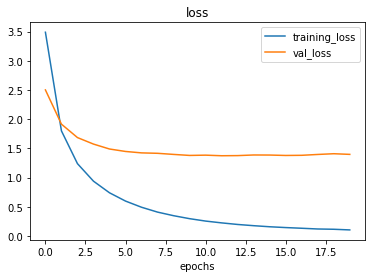

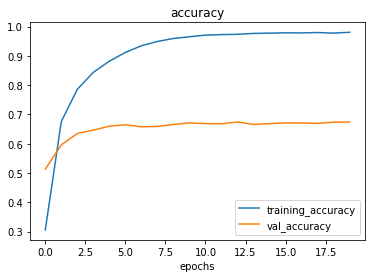

In [ ]:
plot_loss_curves(efficientnet_history_1)

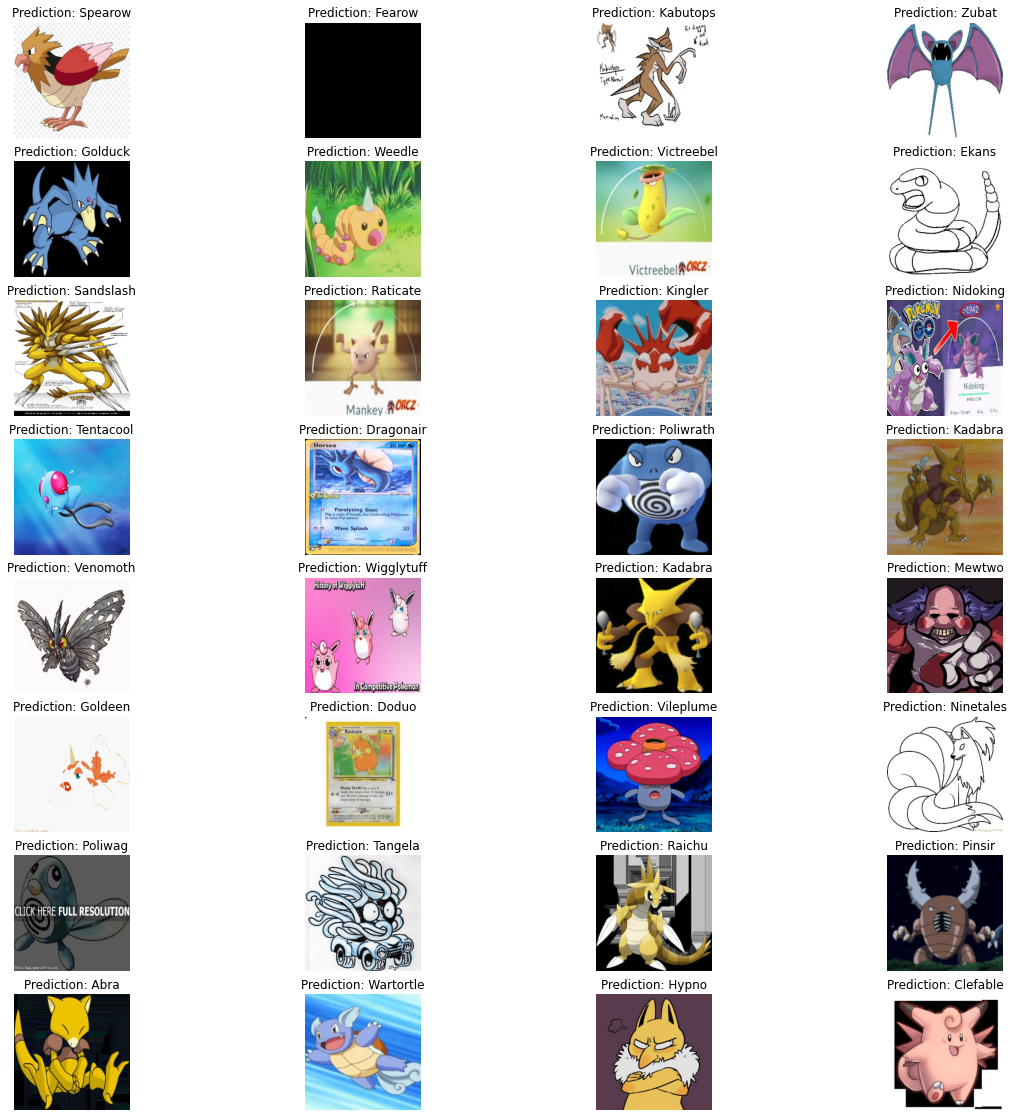

In [ ]:
i = 0
plt.figure(figsize=(20,20))
for index in range(len(test_data[0][0])):
  plt.subplot(8,4, i + 1)
  pred_and_plot(efficientnet_model_1, test_data[0][0][index], class_names)
  i += 1

In [ ]:
resnet_model_2 = create_model(resnet_url,
                            num_classes=train_data.num_classes,
                            image_shape=(256,256),
                            data_augmentation=data_augmentation)

In [ ]:
resnet_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_history_2 = resnet_model_2.fit(train_data,
                 epochs=20,
                 validation_data=validation_data,
                 steps_per_epoch=len(train_data),
                 validation_steps=len(validation_data))

Epoch 1/20
229/229 [==============================] - 38s 153ms/step - loss: 3.7163 - accuracy: 0.2479 - val_loss: 2.6740 - val_accuracy: 0.4176
Epoch 2/20
229/229 [==============================] - 35s 154ms/step - loss: 2.0809 - accuracy: 0.5261 - val_loss: 2.2554 - val_accuracy: 0.4760
Epoch 3/20
229/229 [==============================] - 33s 145ms/step - loss: 1.5762 - accuracy: 0.6334 - val_loss: 2.0856 - val_accuracy: 0.5149
Epoch 4/20
229/229 [==============================] - 35s 153ms/step - loss: 1.3122 - accuracy: 0.6950 - val_loss: 1.9822 - val_accuracy: 0.5441
Epoch 5/20
229/229 [==============================] - 33s 145ms/step - loss: 1.1062 - accuracy: 0.7389 - val_loss: 1.9859 - val_accuracy: 0.5418
Epoch 6/20
229/229 [==============================] - 35s 151ms/step - loss: 0.9793 - accuracy: 0.7678 - val_loss: 1.9182 - val_accuracy: 0.5681
Epoch 7/20
229/229 [==============================] - 33s 144ms/step - loss: 0.8574 - accuracy: 0.7932 - val_loss: 1.9483 - val_ac

In [ ]:
resnet_model_2.evaluate(test_data)

52/52 [==============================] - 6s 118ms/step - loss: 2.2039 - accuracy: 0.5394


[2.2038540840148926, 0.5393532514572144]

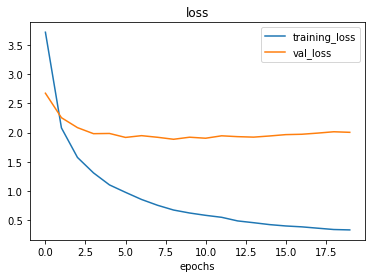

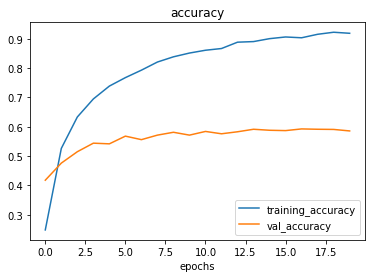

In [ ]:
plot_loss_curves(resnet_history_2)

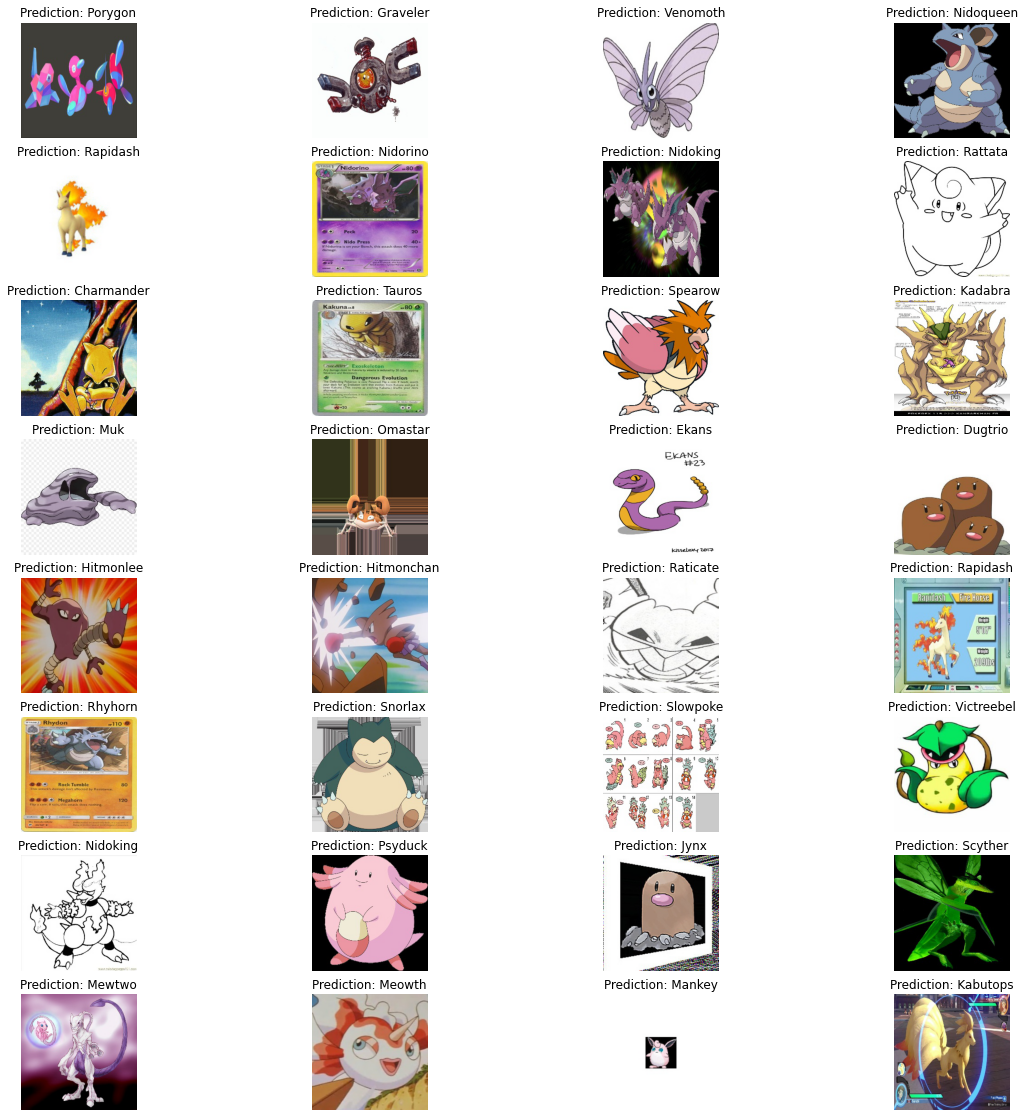

In [ ]:
i = 0
plt.figure(figsize=(20,20))
for index in range(len(test_data[0][0])):
  plt.subplot(8,4, i + 1)
  pred_and_plot(resnet_model_2, test_data[0][0][index], class_names)
  i += 1

In [ ]:
efficientnet_model_2 = create_model(efficient_net_url,
                            num_classes=train_data.num_classes,
                            image_shape=(256,256),
                            data_augmentation=data_augmentation)

In [ ]:
efficientnet_model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
efficientnet_history_2 = efficientnet_model_2.fit(train_data,
                 epochs=20,
                 validation_data=validation_data,
                 steps_per_epoch=len(train_data),
                 validation_steps=len(validation_data))

Epoch 1/20
229/229 [==============================] - 40s 142ms/step - loss: 3.7476 - accuracy: 0.2458 - val_loss: 2.7476 - val_accuracy: 0.4331
Epoch 2/20
229/229 [==============================] - 33s 144ms/step - loss: 2.2611 - accuracy: 0.5441 - val_loss: 2.1577 - val_accuracy: 0.5412
Epoch 3/20
229/229 [==============================] - 32s 138ms/step - loss: 1.7071 - accuracy: 0.6600 - val_loss: 1.8691 - val_accuracy: 0.5955
Epoch 4/20
229/229 [==============================] - 33s 144ms/step - loss: 1.3789 - accuracy: 0.7377 - val_loss: 1.7356 - val_accuracy: 0.6133
Epoch 5/20
229/229 [==============================] - 31s 137ms/step - loss: 1.1707 - accuracy: 0.7711 - val_loss: 1.6510 - val_accuracy: 0.6230
Epoch 6/20
229/229 [==============================] - 33s 145ms/step - loss: 1.0218 - accuracy: 0.7909 - val_loss: 1.5972 - val_accuracy: 0.6293
Epoch 7/20
229/229 [==============================] - 31s 137ms/step - loss: 0.8987 - accuracy: 0.8244 - val_loss: 1.5487 - val_ac

In [ ]:
efficientnet_model_2.evaluate(test_data)

52/52 [==============================] - 6s 115ms/step - loss: 1.6683 - accuracy: 0.6168


[1.6683372259140015, 0.6168395280838013]

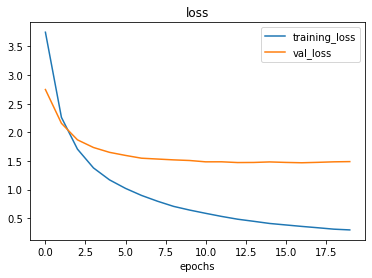

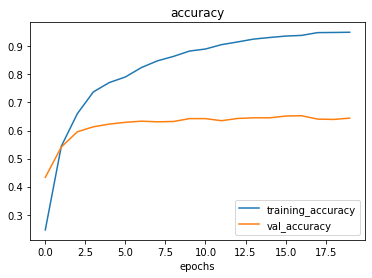

In [ ]:
plot_loss_curves(efficientnet_history_2)

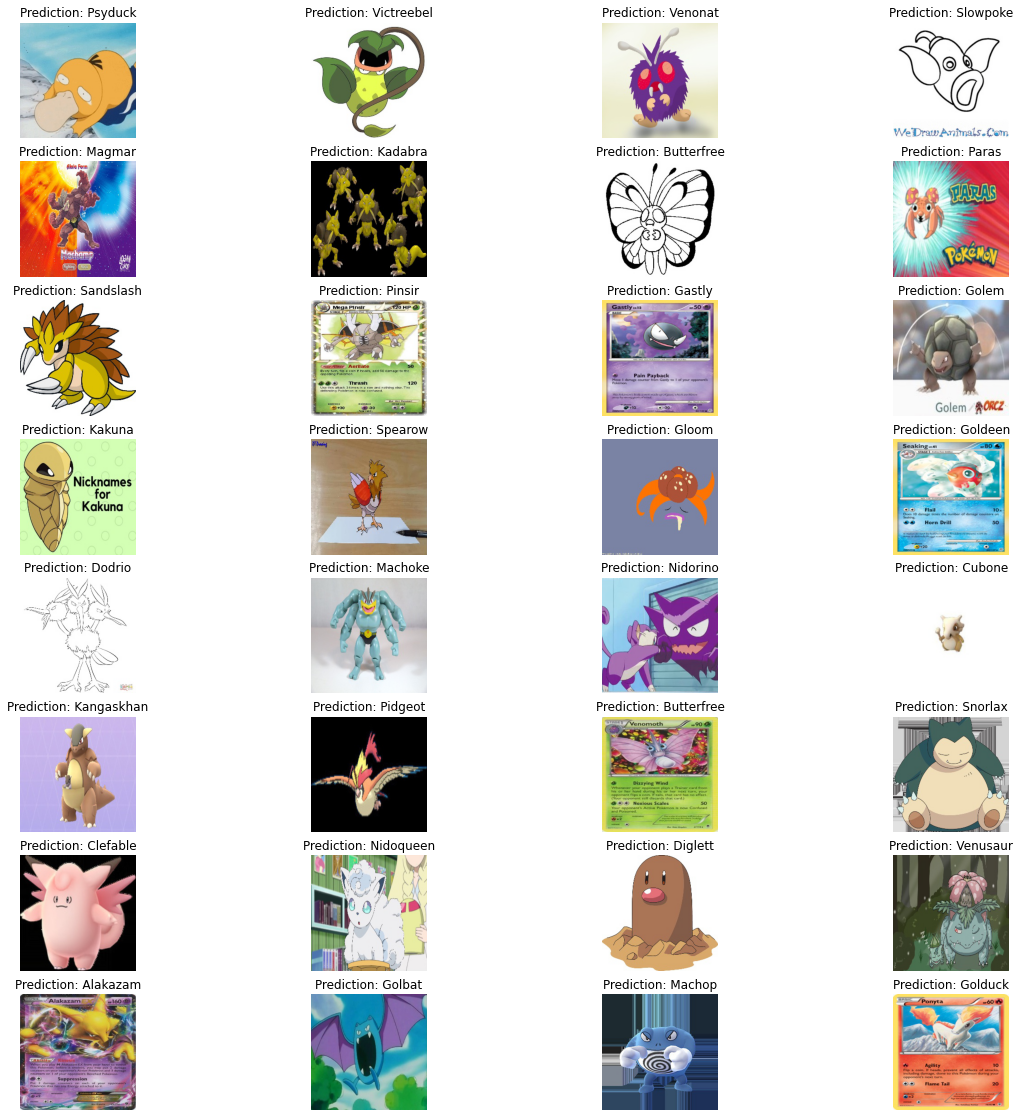

In [ ]:
i = 0
plt.figure(figsize=(20,20))
for index in range(len(test_data[0][0])):
  plt.subplot(8,4, i + 1)
  pred_and_plot(efficientnet_model_2, test_data[0][0][index], class_names)
  i += 1